# Segmentation — DeepLab-V3
**Author:** Sayed Pedram Haeri Boroujeni  
**Position:** PhD Student, Clemson University  
**Affiliation:** Department of Computer Science  
**Email:** shaerib@g.clemson.edu  
**Date Created:** October 10, 2025  

##### 1. Importing Required Libraries

In [1]:
import argparse, os, random, time, math
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.metrics import confusion_matrix
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from sklearn.model_selection import StratifiedKFold
from torchvision.transforms import functional as TF 

##### 2. Checking GPU Availability

In [2]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Device Name: {torch.cuda.get_device_name()}")
else:
    print("CUDA is not available on this system.")

CUDA Available: True
CUDA Version: 12.6
Number of GPUs: 1
Device Name: NVIDIA RTX A5000


##### 3. Reproducibility

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

set_seed(1)

##### 4. Configuration

In [4]:
#data_dir = "ADD YOUR PATH HERE"  
data_dir = "C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset/FESB MLID"  


use_kfold = True
num_folds = 5
num_epochs = 10
batch_size = 8
learning_rate = 1e-4
momentum = 0.9
img_size = 513

##### 5. Dataset Preparation

In [5]:
def prepare_segmentation_dataset(data_dir, img_size=513):
    """
    Prepare dataset for segmentation:
    1. Detect paired image and ground truth (GT) mask files.
    2. Ensure train/test split (if 'val' exists, keep it).
    3. Resize and rename all images & masks sequentially (1, 2, 3, ...).
    4. Save processed images in 'src/' and masks in 'gt/' folders under each split.
    5. Print total sample counts.
    """

    from tqdm import tqdm
    from PIL import Image
    from pathlib import Path

    data_dir = Path(data_dir)
    exts_img = ["*.jpg", "*.jpeg", "*.png", "*.bmp", "*.tiff", "*.webp"]

    # --- Helper to find all images in folder ---
    def all_images_in(folder):
        imgs = []
        for ext in exts_img:
            imgs.extend(Path(folder).rglob(ext))
        return imgs

    # --- Detect main folders ---
    train_dir = data_dir / "train"
    val_dir = data_dir / "val"
    test_dir = data_dir / "test"

    # --- Check existence ---
    splits = []
    if train_dir.exists(): splits.append(train_dir)
    if val_dir.exists(): splits.append(val_dir)
    if test_dir.exists(): splits.append(test_dir)
    if not splits:
        raise RuntimeError("No train/test folders found. Expected at least 'train/' and 'test/'.")

    # --- Iterate over splits ---
    for split_dir in splits:
        print(f"\n⚙️ Processing split: {split_dir.name}")

        # Detect subfolders
        img_dir = split_dir / "src"
        gt_dir  = split_dir / "gt"

        if not img_dir.exists() or not gt_dir.exists():
            raise RuntimeError(f"Expected 'images/' and 'gt/' folders inside {split_dir}")

        img_files = sorted(all_images_in(img_dir))
        gt_files  = sorted(all_images_in(gt_dir))
        if len(img_files) == 0 or len(gt_files) == 0:
            print(f"⚠️ No images or GT masks found in {split_dir}")
            continue

        # --- Check pairs and match ---
        num_pairs = min(len(img_files), len(gt_files))
        print(f"  Found {num_pairs} image–mask pairs.")

        # --- Create output folders ---
        out_img_dir = split_dir / "src_generated"
        out_gt_dir  = split_dir / "gt_generated"
        out_img_dir.mkdir(parents=True, exist_ok=True)
        out_gt_dir.mkdir(parents=True, exist_ok=True)

        # --- Process pairs ---
        for i in tqdm(range(num_pairs), desc=f"{split_dir.name}", ncols=90):
            try:
                img = Image.open(img_files[i]).convert("RGB")
                gt  = Image.open(gt_files[i]).convert("L")

                img = img.resize((img_size, img_size))
                gt  = gt.resize((img_size, img_size), resample=Image.NEAREST)

                # filenames start from 1
                idx = i + 1

                img.save(out_img_dir / f"{idx}.jpg", "JPEG", quality=95)
                gt.save(out_gt_dir / f"{idx}.png", "PNG")

            except Exception as e:
                print(f"❌ Error processing {img_files[i]}: {e}")

        print(f"✅ {split_dir.name}: Saved {num_pairs} paired samples to '{out_img_dir.name}' and '{out_gt_dir.name}'.")

    print("\n🎯 Segmentation dataset preparation completed successfully!")

#Test
prepare_segmentation_dataset(data_dir)


⚙️ Processing split: train
  Found 200 image–mask pairs.


train: 100%|████████████████████████████████████████████| 200/200 [00:13<00:00, 15.00it/s]


✅ train: Saved 200 paired samples to 'src_generated' and 'gt_generated'.

⚙️ Processing split: val
  Found 50 image–mask pairs.


val: 100%|████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.38it/s]


✅ val: Saved 50 paired samples to 'src_generated' and 'gt_generated'.

⚙️ Processing split: test
  Found 150 image–mask pairs.


test: 100%|█████████████████████████████████████████████| 150/150 [00:10<00:00, 14.53it/s]

✅ test: Saved 150 paired samples to 'src_generated' and 'gt_generated'.

🎯 Segmentation dataset preparation completed successfully!


##### 6. Data Loading & Transformations

In [18]:
# Image normalization (ImageNet values)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
img_size = 513  # DeepLab-V3 default input size

# --- Define transforms ---
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

mask_transform = transforms.Compose([
    transforms.Resize((img_size, img_size), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# Custom Dataset for paired src and gt_generated
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        mask = (mask > 0).long()  # binary mask
        return image, mask


# Initialize Datasets
train_dataset = SegmentationDataset(
    os.path.join(data_dir, "train", "src_generated"),
    os.path.join(data_dir, "train", "gt_generated"),
    transform=train_transform,
    target_transform=mask_transform
)

val_dataset = SegmentationDataset(
    os.path.join(data_dir, "val", "src_generated"),
    os.path.join(data_dir, "val", "gt_generated"),
    transform=val_transform,
    target_transform=mask_transform
)

test_dataset = SegmentationDataset(
    os.path.join(data_dir, "test", "src_generated"),
    os.path.join(data_dir, "test", "gt_generated"),
    transform=test_transform,
    target_transform=mask_transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 200 | Val: 50 | Test: 150


##### 7. DeepLab-V3 Model Initialization

In [7]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = deeplabv3_resnet50(weights=weights)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)  # two classes: background & fire
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(momentum, 0.999))

print("DeepLab-V3 initialized and ready for training.")

DeepLab-V3 initialized and ready for training.


##### 8. DeepLab-V3 Training Loop

In [8]:
# Training Function
def train_segmentation(model, criterion, optimizer, train_loader, val_loader,
                       num_epochs, device='cuda', fold=None):
    """Training loop with validation/test, best model saving, and IoU tracking."""
    train_losses, val_losses, val_ious = [], [], []
    best_iou = 0.0

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0

        # ---- Training ----
        for imgs, masks in tqdm(train_loader, desc=f"Fold {fold or 0} | Epoch {epoch}/{num_epochs}", ncols=90):
            imgs, masks = imgs.to(device), masks.squeeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # ---- Validation/Test ----
        model.eval()
        val_loss, iou_scores = 0.0, []

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.squeeze(1).to(device)
                outputs = model(imgs)["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item() * imgs.size(0)

                preds = torch.argmax(outputs, 1)
                intersection = (preds & masks).float().sum((1,2))
                union = (preds | masks).float().sum((1,2))
                iou_scores.extend((intersection / (union + 1e-6)).cpu().numpy())

        val_loss /= len(val_loader.dataset)
        mean_iou = np.mean(iou_scores)
        val_losses.append(val_loss)
        val_ious.append(mean_iou)

        print(f"[Fold {fold or 0}] Epoch {epoch:02d}/{num_epochs} | "
              f"Train Loss {epoch_loss:.4f} | Val Loss {val_loss:.4f} | mIoU {mean_iou:.4f}")

        # ---- Save best model per fold ----
        if mean_iou > best_iou:
            best_iou = mean_iou
            model_name = f"best_deeplabv3_segmentation_fold{fold}.pth" if fold else "best_deeplabv3_segmentation.pth"
            torch.save(model.state_dict(), model_name)

    print(f"\n✅ Training completed for fold {fold or 0}. Best mIoU = {best_iou:.4f}")
    return train_losses, val_losses, val_ious, best_iou


# ============================================================
#  K-Fold Cross-Validation or Fixed Split (Safe Version)
# ============================================================

if use_kfold:
    print(f"🔁 Running {num_folds}-Fold Cross-Validation …\n")

    # Prepare full dataset (train + pseudo-labels for stratification)
    full_dataset = SegmentationDataset(
        os.path.join(data_dir, "train", "src_generated"),
        os.path.join(data_dir, "train", "gt_generated"),
        transform=train_transform,
        target_transform=mask_transform
    )

    # Pseudo-labels (mean mask intensity > 0 ⇒ class 1)
    labels_for_split = []
    for _, mask in full_dataset:
        labels_for_split.append(int(mask.float().mean().item() > 0.01))
    labels_for_split = np.array(labels_for_split)

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = []
    fold_histories = {}

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_for_split)), labels_for_split)):
        print(f"\n===== Fold {fold+1}/{num_folds} =====")

        train_subset = Subset(full_dataset, train_idx)
        val_subset   = Subset(full_dataset, val_idx)

        # SAFE DataLoaders (no multiprocessing)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                  num_workers=0, pin_memory=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                  num_workers=0, pin_memory=True)

        # Re-initialize model per fold
        model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
        model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
        if hasattr(model, "aux_classifier"):
            model.aux_classifier = None
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(momentum, 0.999))

        tr_loss, vl_loss, vl_iou, best_iou = train_segmentation(
            model, criterion, optimizer, train_loader, val_loader,
            num_epochs=num_epochs, device=device, fold=fold+1
        )

        fold_results.append(best_iou)
        fold_histories[fold+1] = {
            "train_losses": tr_loss,
            "val_losses": vl_loss,
            "val_ious": vl_iou,
            "best_iou": best_iou
        }

    print("\n✅ Cross-Validation Complete.")
    print(f"Average mIoU = {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

else:
    print("➡️ Using fixed train/val/test split.\n")

    # SAFE DataLoaders for fixed split
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                              num_workers=0, pin_memory=True)

    # ✅ Use val_loader for validation (keep test for final eval)
    tr_loss, vl_loss, vl_iou, best_iou = train_segmentation(
        model, criterion, optimizer, train_loader, val_loader,
        num_epochs=num_epochs, device=device
    )

    fold_histories = {
        0: {
            "train_losses": tr_loss,
            "val_losses": vl_loss,
            "val_ious": vl_iou,
            "best_iou": best_iou
        }
    }

    print(f"✅ Fixed-split training complete. Best Val mIoU = {best_iou:.4f}")


🔁 Running 5-Fold Cross-Validation …


===== Fold 1/5 =====


Fold 1 | Epoch 1/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.45s/it]


[Fold 1] Epoch 01/10 | Train Loss 0.6009 | Val Loss 0.5904 | mIoU 0.5941


Fold 1 | Epoch 2/10: 100%|████████████████████████████████| 20/20 [00:28<00:00,  1.45s/it]


[Fold 1] Epoch 02/10 | Train Loss 0.5264 | Val Loss 0.5660 | mIoU 0.6796


Fold 1 | Epoch 3/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


[Fold 1] Epoch 03/10 | Train Loss 0.4966 | Val Loss 0.5427 | mIoU 0.6276


Fold 1 | Epoch 4/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


[Fold 1] Epoch 04/10 | Train Loss 0.4707 | Val Loss 0.5397 | mIoU 0.6635


Fold 1 | Epoch 5/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.47s/it]


[Fold 1] Epoch 05/10 | Train Loss 0.4440 | Val Loss 0.5511 | mIoU 0.6796


Fold 1 | Epoch 6/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 1] Epoch 06/10 | Train Loss 0.4459 | Val Loss 0.5639 | mIoU 0.6784


Fold 1 | Epoch 7/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 1] Epoch 07/10 | Train Loss 0.4436 | Val Loss 0.5421 | mIoU 0.6707


Fold 1 | Epoch 8/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 1] Epoch 08/10 | Train Loss 0.4313 | Val Loss 0.5257 | mIoU 0.6815


Fold 1 | Epoch 9/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 1] Epoch 09/10 | Train Loss 0.4117 | Val Loss 0.5565 | mIoU 0.6763


Fold 1 | Epoch 10/10: 100%|███████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


[Fold 1] Epoch 10/10 | Train Loss 0.4044 | Val Loss 0.5413 | mIoU 0.6642

✅ Training completed for fold 1. Best mIoU = 0.6815

===== Fold 2/5 =====


Fold 2 | Epoch 1/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


[Fold 2] Epoch 01/10 | Train Loss 0.6038 | Val Loss 0.5598 | mIoU 0.6452


Fold 2 | Epoch 2/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 2] Epoch 02/10 | Train Loss 0.5319 | Val Loss 0.5112 | mIoU 0.7328


Fold 2 | Epoch 3/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


[Fold 2] Epoch 03/10 | Train Loss 0.5060 | Val Loss 0.5075 | mIoU 0.7177


Fold 2 | Epoch 4/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


[Fold 2] Epoch 04/10 | Train Loss 0.4692 | Val Loss 0.5201 | mIoU 0.7054


Fold 2 | Epoch 5/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


[Fold 2] Epoch 05/10 | Train Loss 0.4714 | Val Loss 0.5101 | mIoU 0.7101


Fold 2 | Epoch 6/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 2] Epoch 06/10 | Train Loss 0.4596 | Val Loss 0.4871 | mIoU 0.7475


Fold 2 | Epoch 7/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 2] Epoch 07/10 | Train Loss 0.4517 | Val Loss 0.5011 | mIoU 0.7098


Fold 2 | Epoch 8/10: 100%|████████████████████████████████| 20/20 [00:31<00:00,  1.59s/it]


[Fold 2] Epoch 08/10 | Train Loss 0.4508 | Val Loss 0.5328 | mIoU 0.6861


Fold 2 | Epoch 9/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]


[Fold 2] Epoch 09/10 | Train Loss 0.4341 | Val Loss 0.5271 | mIoU 0.6896


Fold 2 | Epoch 10/10: 100%|███████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]


[Fold 2] Epoch 10/10 | Train Loss 0.4250 | Val Loss 0.5056 | mIoU 0.7363

✅ Training completed for fold 2. Best mIoU = 0.7475

===== Fold 3/5 =====


Fold 3 | Epoch 1/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.54s/it]


[Fold 3] Epoch 01/10 | Train Loss 0.6686 | Val Loss 0.6341 | mIoU 0.5282


Fold 3 | Epoch 2/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 3] Epoch 02/10 | Train Loss 0.5642 | Val Loss 0.6115 | mIoU 0.6560


Fold 3 | Epoch 3/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


[Fold 3] Epoch 03/10 | Train Loss 0.5160 | Val Loss 0.5335 | mIoU 0.6765


Fold 3 | Epoch 4/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 3] Epoch 04/10 | Train Loss 0.4789 | Val Loss 0.4970 | mIoU 0.7223


Fold 3 | Epoch 5/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


[Fold 3] Epoch 05/10 | Train Loss 0.4721 | Val Loss 0.5434 | mIoU 0.6616


Fold 3 | Epoch 6/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


[Fold 3] Epoch 06/10 | Train Loss 0.4588 | Val Loss 0.5157 | mIoU 0.7319


Fold 3 | Epoch 7/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 3] Epoch 07/10 | Train Loss 0.4485 | Val Loss 0.5046 | mIoU 0.7336


Fold 3 | Epoch 8/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 3] Epoch 08/10 | Train Loss 0.4430 | Val Loss 0.5051 | mIoU 0.7083


Fold 3 | Epoch 9/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 3] Epoch 09/10 | Train Loss 0.4225 | Val Loss 0.4967 | mIoU 0.7304


Fold 3 | Epoch 10/10: 100%|███████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


[Fold 3] Epoch 10/10 | Train Loss 0.4201 | Val Loss 0.5109 | mIoU 0.7260

✅ Training completed for fold 3. Best mIoU = 0.7336

===== Fold 4/5 =====


Fold 4 | Epoch 1/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 4] Epoch 01/10 | Train Loss 0.6039 | Val Loss 0.5395 | mIoU 0.6934


Fold 4 | Epoch 2/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


[Fold 4] Epoch 02/10 | Train Loss 0.5281 | Val Loss 0.5337 | mIoU 0.6885


Fold 4 | Epoch 3/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]


[Fold 4] Epoch 03/10 | Train Loss 0.5011 | Val Loss 0.5510 | mIoU 0.6802


Fold 4 | Epoch 4/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


[Fold 4] Epoch 04/10 | Train Loss 0.4886 | Val Loss 0.5278 | mIoU 0.6943


Fold 4 | Epoch 5/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


[Fold 4] Epoch 05/10 | Train Loss 0.4743 | Val Loss 0.5388 | mIoU 0.6610


Fold 4 | Epoch 6/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


[Fold 4] Epoch 06/10 | Train Loss 0.4542 | Val Loss 0.5393 | mIoU 0.6615


Fold 4 | Epoch 7/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


[Fold 4] Epoch 07/10 | Train Loss 0.4337 | Val Loss 0.5255 | mIoU 0.7160


Fold 4 | Epoch 8/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 4] Epoch 08/10 | Train Loss 0.4287 | Val Loss 0.5123 | mIoU 0.7047


Fold 4 | Epoch 9/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 4] Epoch 09/10 | Train Loss 0.4184 | Val Loss 0.5240 | mIoU 0.6888


Fold 4 | Epoch 10/10: 100%|███████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 4] Epoch 10/10 | Train Loss 0.4182 | Val Loss 0.5150 | mIoU 0.6953

✅ Training completed for fold 4. Best mIoU = 0.7160

===== Fold 5/5 =====


Fold 5 | Epoch 1/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.52s/it]


[Fold 5] Epoch 01/10 | Train Loss 0.6776 | Val Loss 0.6375 | mIoU 0.5717


Fold 5 | Epoch 2/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]


[Fold 5] Epoch 02/10 | Train Loss 0.5634 | Val Loss 0.6384 | mIoU 0.5639


Fold 5 | Epoch 3/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


[Fold 5] Epoch 03/10 | Train Loss 0.5285 | Val Loss 0.5064 | mIoU 0.7391


Fold 5 | Epoch 4/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.50s/it]


[Fold 5] Epoch 04/10 | Train Loss 0.4918 | Val Loss 0.5114 | mIoU 0.7142


Fold 5 | Epoch 5/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.49s/it]


[Fold 5] Epoch 05/10 | Train Loss 0.4610 | Val Loss 0.5725 | mIoU 0.6491


Fold 5 | Epoch 6/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.51s/it]


[Fold 5] Epoch 06/10 | Train Loss 0.4582 | Val Loss 0.5003 | mIoU 0.7217


Fold 5 | Epoch 7/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]


[Fold 5] Epoch 07/10 | Train Loss 0.4483 | Val Loss 0.5845 | mIoU 0.6393


Fold 5 | Epoch 8/10: 100%|████████████████████████████████| 20/20 [00:29<00:00,  1.50s/it]


[Fold 5] Epoch 08/10 | Train Loss 0.4250 | Val Loss 0.5001 | mIoU 0.7198


Fold 5 | Epoch 9/10: 100%|████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


[Fold 5] Epoch 09/10 | Train Loss 0.4204 | Val Loss 0.5201 | mIoU 0.7077


Fold 5 | Epoch 10/10: 100%|███████████████████████████████| 20/20 [00:30<00:00,  1.55s/it]


[Fold 5] Epoch 10/10 | Train Loss 0.4172 | Val Loss 0.5331 | mIoU 0.7120

✅ Training completed for fold 5. Best mIoU = 0.7391

✅ Cross-Validation Complete.
Average mIoU = 0.7235 ± 0.0234


##### 9. Plot Training Curves

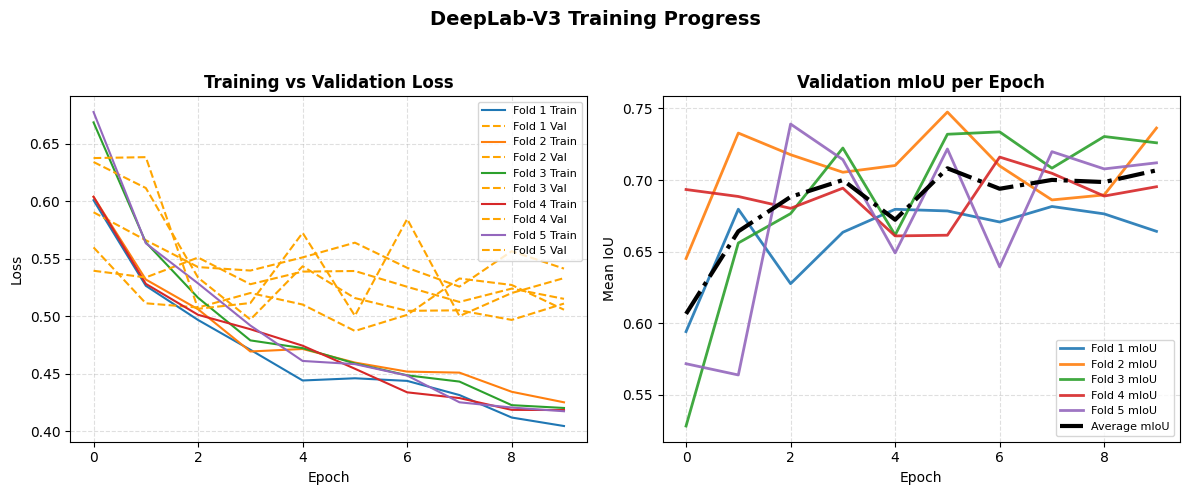

In [9]:
def plot_segmentation_curves(fold_histories, use_kfold=False):
    plt.figure(figsize=(12, 5))

    # ============================================================
    # Training vs Validation Loss
    # ============================================================
    plt.subplot(1, 2, 1)
    color_cycle = plt.cm.tab10.colors  # consistent color palette
    for i, (fold, hist) in enumerate(fold_histories.items()):
        color = color_cycle[i % len(color_cycle)]
        label_prefix = f"Fold {fold}" if use_kfold else "Run"
        plt.plot(hist["train_losses"], label=f"{label_prefix} Train", color=color, linestyle='-')
        plt.plot(hist["val_losses"],   label=f"{label_prefix} Val",   color='Orange', linestyle='--')

    plt.title("Training vs Validation Loss", fontsize=12, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(fontsize=8)

    # ============================================================
    # Validation mIoU Curves
    # ============================================================
    plt.subplot(1, 2, 2)
    all_val_ious = []

    for i, (fold, hist) in enumerate(fold_histories.items()):
        color = color_cycle[i % len(color_cycle)]
        label_prefix = f"Fold {fold}" if use_kfold else "Run"
        plt.plot(hist["val_ious"], label=f"{label_prefix} mIoU", linewidth=2, alpha=0.9, color=color)
        all_val_ious.append(hist["val_ious"])

    # Plot average mIoU curve for K-Fold
    if use_kfold and len(all_val_ious) > 1:
        min_len = min(len(v) for v in all_val_ious)
        mean_iou = np.mean([v[:min_len] for v in all_val_ious], axis=0)
        plt.plot(mean_iou, color='black', linewidth=3, label="Average mIoU", linestyle='-.')

    plt.title("Validation mIoU per Epoch", fontsize=12, fontweight="bold")
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend(fontsize=8)

    plt.suptitle("DeepLab-V3 Training Progress", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ============================================================
# Run Plot Function
# ============================================================
if "fold_histories" in locals() and len(fold_histories) > 0:
    plot_segmentation_curves(fold_histories, use_kfold=use_kfold)
else:
    print(" No training history found. Please run Cell 8 first.")


##### 10. Evaluation on Test Set

In [10]:
def evaluate_segmentation_model(model, test_loader, device='cuda'):
    """Evaluate DeepLabV3 on the test set and compute IoU, F1, Accuracy, and Specificity."""
    model.eval()
    ious, f1s, accuracies, specificities = [], [], [], []

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc="Evaluating on Test Set", ncols=90):
            imgs, masks = imgs.to(device), masks.squeeze(1).to(device)
            outputs = model(imgs)["out"]
            preds = torch.argmax(outputs, 1)

            # Compute metrics per batch
            intersection = (preds & masks).float().sum((1, 2))
            union = (preds | masks).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).cpu().numpy()

            tp = ((preds == 1) & (masks == 1)).sum().item()
            tn = ((preds == 0) & (masks == 0)).sum().item()
            fp = ((preds == 1) & (masks == 0)).sum().item()
            fn = ((preds == 0) & (masks == 1)).sum().item()

            f1 = (2 * tp) / (2 * tp + fp + fn + 1e-6)
            acc = (tp + tn) / (tp + tn + fp + fn + 1e-6)
            spec = tn / (tn + fp + 1e-6)

            ious.extend(iou)
            f1s.append(f1)
            accuracies.append(acc)
            specificities.append(spec)

    # Aggregate results
    mean_iou = np.mean(ious)
    mean_f1 = np.mean(f1s)
    mean_acc = np.mean(accuracies)
    mean_spec = np.mean(specificities)

    print(f"\n✅ Test Evaluation Complete:")
    print(f"  Mean IoU:         {mean_iou:.4f}")
    print(f"  Mean F1-Score:    {mean_f1:.4f}")
    print(f"  Mean Accuracy:    {mean_acc:.4f}")
    print(f"  Mean Specificity: {mean_spec:.4f}")

    return {
        "IoU": mean_iou,
        "F1": mean_f1,
        "Accuracy": mean_acc,
        "Specificity": mean_spec
    }


# ============================================================
# Load Best Model(s) and Evaluate
# ============================================================

if use_kfold:
    print("\n🔍 Evaluating best model from each fold on the test set...\n")
    test_results = {}

    for fold in range(1, num_folds + 1):
        model_path = f"best_deeplabv3_segmentation_fold{fold}.pth"
        if not os.path.exists(model_path):
            print(f"⚠️ Model checkpoint not found: {model_path}")
            continue

        # Reload model for this fold
        model = deeplabv3_resnet50(weights=None)
        model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
        if hasattr(model, "aux_classifier"):
            model.aux_classifier = None  # avoid key mismatch errors

        # Load weights safely
        state_dict = torch.load(model_path, map_location=device)
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        if unexpected:
            print(f"   Ignored keys during loading: {unexpected}")

        model = model.to(device)

        print(f"\n===== Evaluating Fold {fold} =====")
        metrics = evaluate_segmentation_model(model, test_loader, device=device)
        test_results[fold] = metrics

    # Average metrics across folds
    if len(test_results) > 0:
        metric_names = list(test_results[list(test_results.keys())[0]].keys())
        avg_metrics = {m: np.mean([r[m] for r in test_results.values()]) for m in metric_names}

        print("\n📊 Average Test Metrics Across Folds:")
        for k, v in avg_metrics.items():
            print(f"  {k}: {v:.4f}")

else:
    print("\n🔍 Evaluating single best model on test set...\n")

    model_path = "best_deeplabv3_segmentation.pth"
    if not os.path.exists(model_path):
        raise FileNotFoundError("❌ Best model checkpoint not found. Run training first.")

    # Load best model
    model = deeplabv3_resnet50(weights=None)
    model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
    if hasattr(model, "aux_classifier"):
        model.aux_classifier = None

    # Load weights safely
    state_dict = torch.load(model_path, map_location=device)
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if unexpected:
        print(f"Ignored keys during loading: {unexpected}")

    model = model.to(device)

    # Evaluate on held-out test set 
    test_metrics = evaluate_segmentation_model(model, test_loader, device=device)


🔍 Evaluating best model from each fold on the test set...


===== Evaluating Fold 1 =====


Evaluating on Test Set: 100%|█████████████████████████████| 19/19 [00:08<00:00,  2.11it/s]



✅ Test Evaluation Complete:
  Mean IoU:         0.6591
  Mean F1-Score:    0.7935
  Mean Accuracy:    0.7272
  Mean Specificity: 0.4148

===== Evaluating Fold 2 =====


Evaluating on Test Set: 100%|█████████████████████████████| 19/19 [00:04<00:00,  3.83it/s]



✅ Test Evaluation Complete:
  Mean IoU:         0.6635
  Mean F1-Score:    0.7986
  Mean Accuracy:    0.7196
  Mean Specificity: 0.2803

===== Evaluating Fold 3 =====


Evaluating on Test Set: 100%|█████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]



✅ Test Evaluation Complete:
  Mean IoU:         0.6558
  Mean F1-Score:    0.7913
  Mean Accuracy:    0.7133
  Mean Specificity: 0.3017

===== Evaluating Fold 4 =====


Evaluating on Test Set: 100%|█████████████████████████████| 19/19 [00:05<00:00,  3.74it/s]



✅ Test Evaluation Complete:
  Mean IoU:         0.6575
  Mean F1-Score:    0.7877
  Mean Accuracy:    0.7060
  Mean Specificity: 0.3000

===== Evaluating Fold 5 =====


Evaluating on Test Set: 100%|█████████████████████████████| 19/19 [00:05<00:00,  3.69it/s]


✅ Test Evaluation Complete:
  Mean IoU:         0.6582
  Mean F1-Score:    0.7924
  Mean Accuracy:    0.7183
  Mean Specificity: 0.3225

📊 Average Test Metrics Across Folds:
  IoU: 0.6588
  F1: 0.7927
  Accuracy: 0.7169
  Specificity: 0.3239


##### 11. Example Predictions

In [12]:
# --- ImageNet normalization (same as used in training) ---
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def denormalize(tensor):
    """Undo normalization for visualization."""
    return torch.clamp(tensor * std + mean, 0, 1)

def visualize_segmentation_predictions(model, dataset, device='cuda', num_samples=5):
    """Visualize segmentation predictions using true-color images."""
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    plt.figure(figsize=(15, num_samples * 3))
    for i, idx in enumerate(indices):
        img, gt = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)
        gt_tensor = gt.squeeze(0)

        with torch.no_grad():
            output = model(img_tensor)["out"]
            pred = torch.argmax(output, dim=1).squeeze(0).cpu()

        # --- Denormalize image for true color display
        img_denorm = denormalize(img_tensor.squeeze(0).cpu())
        img_disp = TF.to_pil_image(img_denorm)

        # Convert masks to grayscale images
        gt_disp = Image.fromarray((gt_tensor.numpy() * 255).astype(np.uint8))
        pred_disp = Image.fromarray((pred.numpy() * 255).astype(np.uint8))

        # Plot triple: Input / Ground Truth / Prediction
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(img_disp)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(gt_disp, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(pred_disp, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ============================================================
# Load Best Model and Visualize
# ============================================================

print("\n Generating Example Predictions \n")

if use_kfold:
    best_fold = max(fold_histories, key=lambda f: fold_histories[f]["best_iou"])
    model_path = f"best_deeplabv3_segmentation_fold{best_fold}.pth"
    print(f"Using best fold model: Fold {best_fold}")
else:
    model_path = "best_deeplabv3_segmentation.pth"

# Load model safely
model = deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
state_dict = torch.load(model_path, map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
if unexpected:
    print(f" Ignored keys during loading: {unexpected}")

model = model.to(device)

# Visualize predictions
visualize_segmentation_predictions(model, test_dataset, device=device, num_samples=5)


 Generating Example Predictions 

Using best fold model: Fold 2


##### 12. Cross-Dataset Evaluation

In [21]:
base_path = "C:/Users/shaerib/OneDrive - Clemson University/Desktop/Dataset"

# Toggle which datasets you want to evaluate 
test_datasets = {
    "FLAME1":    False,
    "BA-UAV":    False,
    "BoWFire":   False,
    "FESB MLID": True,
}

# Evaluation 
def evaluate_segmentation_on_dataset(model, dataset_path, device="cuda"):
    """
    Evaluate DeepLab-V3 segmentation model on an external dataset.
    Expects folder structure:
        dataset_path/
            test/
                src/ (images)
                gt/  (ground truth masks)
    """
    dataset_path = Path(dataset_path)
    test_dir = dataset_path / "test"

    if not test_dir.exists():
        print(f"⚠️ Skipping {dataset_path.name} — no 'test/' folder found.")
        return None

    img_dir = test_dir / "src_generated"
    gt_dir  = test_dir / "gt_generated"
    if not img_dir.exists() or not gt_dir.exists():
        print(f"⚠️ Skipping {dataset_path.name} — missing 'src_generated' or 'gt_generated' folder.")
        return None

    # Create dataset + loader
    test_dataset = SegmentationDataset(
        image_dir=str(img_dir),
        mask_dir=str(gt_dir),
        transform=test_transform,
        target_transform=mask_transform
    )
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

    # Evaluate model
    model.eval()
    ious, f1s, accuracies, specificities = [], [], [], []

    with torch.no_grad():
        for imgs, masks in tqdm(test_loader, desc=f"Evaluating {dataset_path.name}", ncols=90):
            imgs, masks = imgs.to(device), masks.squeeze(1).to(device)
            outputs = model(imgs)["out"]
            preds = torch.argmax(outputs, 1)

            # --- Compute metrics per batch ---
            intersection = (preds & masks).float().sum((1, 2))
            union = (preds | masks).float().sum((1, 2))
            iou = (intersection / (union + 1e-6)).cpu().numpy()

            tp = ((preds == 1) & (masks == 1)).sum().item()
            tn = ((preds == 0) & (masks == 0)).sum().item()
            fp = ((preds == 1) & (masks == 0)).sum().item()
            fn = ((preds == 0) & (masks == 1)).sum().item()

            f1 = (2 * tp) / (2 * tp + fp + fn + 1e-6)
            acc = (tp + tn) / (tp + tn + fp + fn + 1e-6)
            spec = tn / (tn + fp + 1e-6)

            ious.extend(iou)
            f1s.append(f1)
            accuracies.append(acc)
            specificities.append(spec)

    # Aggregate metrics
    return {
        "IoU": np.mean(ious),
        "F1": np.mean(f1s),
        "Accuracy": np.mean(accuracies),
        "Specificity": np.mean(specificities),
    }


# ============================================================
# Load the best trained segmentation model
# ============================================================

print("\n🚀 Starting Cross-Dataset Evaluation ...\n")
device = "cuda" if torch.cuda.is_available() else "cpu"

if use_kfold:
    best_fold = max(fold_histories, key=lambda f: fold_histories[f]["best_iou"])
    model_path = f"best_deeplabv3_segmentation_fold{best_fold}.pth"
    print(f"🧠 Using best fold model: Fold {best_fold}")
else:
    model_path = "best_deeplabv3_segmentation.pth"

# --- Load DeepLab-V3 model safely ---
model = deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
if hasattr(model, "aux_classifier"):
    model.aux_classifier = None

state_dict = torch.load(model_path, map_location=device)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
if unexpected:
    print(f"⚠️ Ignored keys during loading: {unexpected}")

model = model.to(device)

# ============================================================
# Evaluate Sequentially Across Datasets
# ============================================================

results = {}

for name, active in test_datasets.items():
    if not active:
        continue

    dataset_dir = Path(base_path) / name
    if not dataset_dir.exists():
        print(f"❌ Dataset not found: {dataset_dir}")
        continue

    print(f"\n===== Evaluating on {name} =====")
    metrics = evaluate_segmentation_on_dataset(model, dataset_dir, device=device)
    if metrics is not None:
        print(f"\n📊 Results on {name}:")
        for k, v in metrics.items():
            print(f"  {k:<12}: {v:.4f}")
        results[name] = metrics
    else:
        print(f"⚠️ Evaluation skipped for {name}.")

# ============================================================
# Summary of Results
# ============================================================

print("\n📈 Summary of Cross-Dataset Results:")
for name, m in results.items():
    print(f"  {name:<20} | IoU: {m['IoU']:.4f} | F1: {m['F1']:.4f} | Acc: {m['Accuracy']:.4f} | Spec: {m['Specificity']:.4f}")

if results:
    avg_metrics = {k: np.mean([v[k] for v in results.values()]) for k in ["IoU", "F1", "Accuracy", "Specificity"]}
    print("\n⭐ Average Across Tested Datasets:")
    for k, v in avg_metrics.items():
        print(f"  {k:<12}: {v:.4f}")
else:
    print("❌ No datasets evaluated — enable at least one in test_datasets.")



🚀 Starting Cross-Dataset Evaluation ...

🧠 Using best fold model: Fold 2

===== Evaluating on FESB MLID =====


Evaluating FESB MLID: 100%|███████████████████████████████| 38/38 [00:05<00:00,  7.10it/s]


📊 Results on FESB MLID:
  IoU         : 0.6635
  F1          : 0.7924
  Accuracy    : 0.7199
  Specificity : 0.2763

📈 Summary of Cross-Dataset Results:
  FESB MLID            | IoU: 0.6635 | F1: 0.7924 | Acc: 0.7199 | Spec: 0.2763

⭐ Average Across Tested Datasets:
  IoU         : 0.6635
  F1          : 0.7924
  Accuracy    : 0.7199
  Specificity : 0.2763
